# Первый запуск

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

from math import log10, log
from random import shuffle

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('train.csv')

In [3]:
def find_numer_cols(df, exept = []):
    numerical_mask = [np.issubdtype(df[name].dtype, np.number) and not name in exept for name in df.columns]
    return df.columns[numerical_mask]

numerical_columns = find_numer_cols(df)
print(numerical_columns)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


In [4]:
def create_dict(names, val = 0):
    to_ret = {}
    for i in names:
        to_ret[i] = val
    return to_ret

# Перобразования входных данных

## Обработка счетчиков

### Разбиение фиксированной ширины

### Квантильное разбиение

<AxesSubplot:>

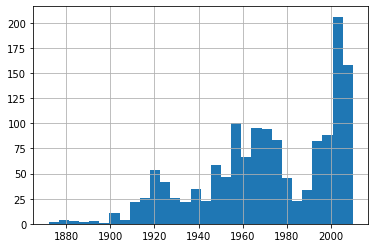

In [56]:
df['YearBuilt'].hist(bins=30)

[11  7  0  9 12  1  2  5 13  4  6 14  3  8 10]


0.066667    1920.0
0.133333    1931.0
0.200000    1947.8
0.266667    1955.0
0.333333    1960.0
0.400000    1965.0
0.466667    1970.0
0.533333    1976.0
0.600000    1984.0
0.666667    1994.0
0.733333    1999.0
0.800000    2003.0
0.866667    2005.0
0.933333    2006.0
Name: YearBuilt, dtype: float64

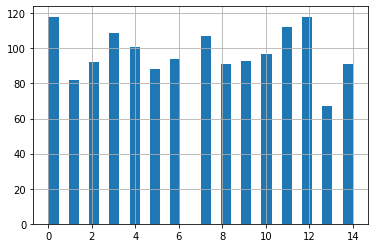

In [57]:
# Применяет квантильное разделение к столбцу
output_par = pd.qcut(df['YearBuilt'], 15, labels = False)

print(output_par.unique())
output_par.hist(bins=30)

# Возвращает значение квантелей
df['YearBuilt'].quantile([x/15 for x in range(1, 15)])

### Логарифмическое преобразование

<AxesSubplot:>

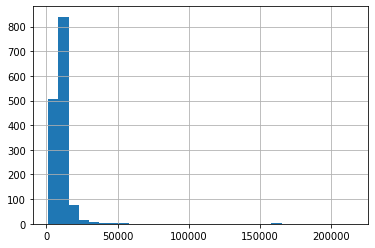

In [58]:
df['LotArea'].hist(bins=30)

<AxesSubplot:>

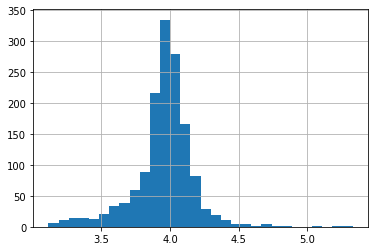

In [59]:
df['LotArea'].apply(lambda x: log10(x)).hist(bins=30)

### Логарифмическое преобразование в действии

In [60]:
sk_lsm = sk.linear_model.LinearRegression()

In [61]:
cross_val_score(sk_lsm,  df[['LotArea']], df['SalePrice']).mean()

0.03712896459474102

In [62]:
df['LogLotArea'] = df['LotArea'].apply(lambda x: log10(x))
cross_val_score(sk_lsm,  df[['LogLotArea']], df['SalePrice']).mean()

0.14368508754489384

### Преобразование Бокса-Кокса

In [63]:
def box_cox(x, lam):
    if(lam == 0):
        return log(x)
    return (x**lam - 1)/lam

## Маштабирование признаков или нормализация

### Масштабирование по минимаксу

In [105]:
class min_max:
    
    def tr(self, df):
        self.min = {}
        self.range = {}
        to_ret = df[:]
        for col in df.columns:
            self.min[col] = df[col].min()
            self.range[col] = df[col].max() - self.min[col]
            to_ret[col] -= self.min[col]
            to_ret[col] /= self.range[col]
        return to_ret
    
    def inv(self, df):
        to_ret = df[:]
        for col in self.min.keys():            
            to_ret[col] = to_ret[col]*self.range[col] + self.min[col]
        return to_ret

In [109]:
df['LogLotArea']

0       0.812913
1       0.868328
2       0.937209
3       0.866060
4       1.040176
          ...   
1455    0.784617
1456    1.005807
1457    0.842321
1458    0.873589
1459    0.883312
Name: LogLotArea, Length: 1460, dtype: float64

In [112]:
mnmx = min_max()
temp = mnmx.tr(df[[ 'LogLotArea']])
print(temp)
print(mnmx.inv(temp))

      LogLotArea
0       0.366344
1       0.391317
2       0.422359
3       0.390295
4       0.468761
...          ...
1455    0.353592
1456    0.453273
1457    0.379597
1458    0.393688
1459    0.398069

[1460 rows x 1 columns]
      LogLotArea
0       0.812913
1       0.868328
2       0.937209
3       0.866060
4       1.040176
...          ...
1455    0.784617
1456    1.005807
1457    0.842321
1458    0.873589
1459    0.883312

[1460 rows x 1 columns]


### Стандартизация(масштабирование дисперсии)

In [114]:
class mean_std:
    
    def tr(self, df):
        self.mean = {}
        self.std = {}
        to_ret = df[:]
        for col in df.columns:
            self.mean[col] = df[col].mean()
            self.std[col] = df[col].std()
            to_ret[col] -= self.mean[col]
            to_ret[col] /= self.std[col]
        return to_ret
    
    def inv(self, df):
        to_ret = df[:]
        for col in self.mean.keys():            
            to_ret[col] = to_ret[col]*self.std[col] + self.mean[col]
        return to_ret

In [115]:
df['LogLotArea']

0       0.812913
1       0.868328
2       0.937209
3       0.866060
4       1.040176
          ...   
1455    0.784617
1456    1.005807
1457    0.842321
1458    0.873589
1459    0.883312
Name: LogLotArea, Length: 1460, dtype: float64

In [116]:
mnstd = mean_std()
temp = mnstd.tr(df[[ 'LogLotArea']])
print(temp)
print(mnstd.inv(temp))

      LogLotArea
0      -0.133185
1       0.113403
2       0.419917
3       0.103311
4       0.878108
...          ...
1455   -0.259100
1456    0.725171
1457   -0.002324
1458    0.136814
1459    0.180080

[1460 rows x 1 columns]
      LogLotArea
0       0.812913
1       0.868328
2       0.937209
3       0.866060
4       1.040176
...          ...
1455    0.784617
1456    1.005807
1457    0.842321
1458    0.873589
1459    0.883312

[1460 rows x 1 columns]


### Нормализация l^2

In [118]:
class l2:
    
    def tr(self, df):
        self.euc = {}
        to_ret = df[:]
        for col in df.columns:
            self.euc[col] = sum(df[col]**2)**(0.5)
            to_ret[col] /= self.euc[col]
        return to_ret
    
    def inv(self, df):
        to_ret = df[:]
        for col in self.euc.keys():            
            to_ret[col] *= self.euc[col]
        return to_ret

In [119]:
df['LogLotArea']

0       0.812913
1       0.868328
2       0.937209
3       0.866060
4       1.040176
          ...   
1455    0.784617
1456    1.005807
1457    0.842321
1458    0.873589
1459    0.883312
Name: LogLotArea, Length: 1460, dtype: float64

In [120]:
l2_norm = l2()
temp = l2_norm.tr(df[[ 'LogLotArea']])
print(temp)
print(l2_norm.inv(temp))

      LogLotArea
0       0.024390
1       0.026053
2       0.028120
3       0.025985
4       0.031209
...          ...
1455    0.023541
1456    0.030178
1457    0.025273
1458    0.026211
1459    0.026503

[1460 rows x 1 columns]
      LogLotArea
0       0.812913
1       0.868328
2       0.937209
3       0.866060
4       1.040176
...          ...
1455    0.784617
1456    1.005807
1457    0.842321
1458    0.873589
1459    0.883312

[1460 rows x 1 columns]


## Взаимодействие признаков

In [169]:
num_col = find_numer_cols(df, ['LogLotArea', 'SalePrice'])
nan_mask = list(df[num_col].isna().sum() == 0)
num_col = num_col[nan_mask]
y = df[['SalePrice']]

In [163]:
df1 = df[num_col]
df1.shape

(1460, 34)

In [168]:
# interaction_only = True- исключает вторые степени фичей
df2 = sk.preprocessing.PolynomialFeatures(interaction_only = True, include_bias = False).fit_transform(df1)
df2.shape

(1460, 595)

In [170]:
x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(df1, df2, y, test_size = 0.3, random_state = 42)

In [182]:
lsm1 = linear_model.LinearRegression().fit(x1_train, y_train)
lsm2 = linear_model.LinearRegression().fit(x2_train, y_train)

print('x1', mse(y_test, lsm1.predict(x1_test)))
print('x2', mse(y_test, lsm2.predict(x2_test)))

x1 1281871520.8770552
x2 3.090109810935875e+25


## Отбор признаков

### Фильтрация

### Метод обертывания

### Встроеные методы

# Текстовые данные: выравнивание, фильтрация, разбиение

## Множество слов 

In [5]:
text = 'it is a puppy and it is extremely cute'
word_of_set = [
    'it',
    'they',
    'puppy',
    'and',
    'cat',
    'cute',
    'extremely'
]

In [6]:
def fill_dict(wd, text):
    for i in text:
        if i in wd.keys():
            wd[i] += 1

In [7]:
word_dict = create_dict(word_of_set)
fill_dict(word_dict, text.split(' '))
word_dict

{'it': 2, 'they': 0, 'puppy': 1, 'and': 1, 'cat': 0, 'cute': 1, 'extremely': 1}

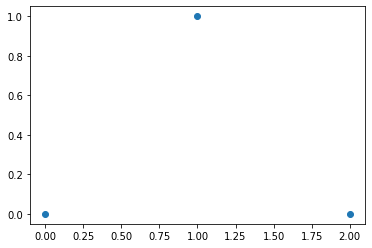

In [8]:
text1 = 'it is cute puppy and cute cat'
text2 = 'it is cute puppy and ugly cat'
text3 = 'it is terrible'

word_dict1 = create_dict(['cute', 'ugly'])
word_dict2 = create_dict(['cute', 'ugly'])
word_dict3 = create_dict(['cute', 'ugly'])

fill_dict(word_dict1, text1.split(' '))
fill_dict(word_dict2, text2.split(' '))
fill_dict(word_dict3, text3.split(' '))

x = [word_dict1['cute'], word_dict2['cute'], word_dict3['cute']]
y = [word_dict1['ugly'], word_dict2['ugly'], word_dict3['ugly']]

plt.scatter(x,y)